In [1]:
!pip install -q tensorflow-ranking

     |████████████████████████████████| 141 kB 8.0 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 1.6 MB 45.4 MB/s 
     |████████████████████████████████| 438 kB 60.8 MB/s 
     |████████████████████████████████| 5.8 MB 46.9 MB/s 


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path

In [23]:
import matplotlib.pyplot as plt

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_ranking as tfr
from tensorflow.keras import optimizers

In [3]:
import tensorflow_datasets as tfds
ratings_data = tfds.load('movielens/100k-ratings', split="train")
fetures_data = tfds.load('movielens/100k-movies', split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incomplete0R8Q5P/movielens-train.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incompleteQ8NAMQ/movielens-train.tfrecord


  0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


In [4]:
ratings_data = ratings_data.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

In [5]:
feature_data = fetures_data.map(lambda x: x["movie_title"])
users = ratings_data.map(lambda x: x["user_id"])

In [8]:
# Build vocabulary
user_ids_vocabulary = layers.experimental.preprocessing.StringLookup(
    mask_token=None) 
movie_titles_vocabulary = layers.experimental.preprocessing.StringLookup(
    mask_token=None)

user_ids_vocabulary.adapt(users.batch(1000))
movie_titles_vocabulary.adapt(feature_data.batch(1000))

In [9]:
key_func = lambda x: user_ids_vocabulary(x["user_id"])
reduce_func = lambda key, dataset: dataset.batch(100)

# training datas
train = ratings_data.group_by_window(
    key_func=key_func, reduce_func=reduce_func, window_size=100)

In [10]:
print(train)
for x in train.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}")
    print(f"Example values of {key}: {value[:5].numpy()}")
    print()

<_GroupByWindowDataset element_spec={'movie_title': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>
Shape of movie_title: (100,)
Example values of movie_title: [b'Man Who Would Be King, The (1975)' b'Silence of the Lambs, The (1991)'
 b'Next Karate Kid, The (1994)' b'2001: A Space Odyssey (1968)'
 b'Usual Suspects, The (1995)']

Shape of user_id: (100,)
Example values of user_id: [b'405' b'405' b'405' b'405' b'405']

Shape of user_rating: (100,)
Example values of user_rating: [1. 4. 1. 5. 5.]



In [11]:
from typing import Dict, Tuple
def _features_and_labels(
    x: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
  labels = x.pop("user_rating")
  return x, labels
 
train = train.map(_features_and_labels)
 
train = train.apply(
    tf.data.experimental.dense_to_ragged_batch(batch_size=32))

In [13]:
class RankingModel(Model):
  def __init__(self, user_vocab, movie_vocab):
    super().__init__()
    self.user_vocab = user_vocab
    self.movie_vocab = movie_vocab
    self.user_embed = layers.Embedding(user_vocab.vocabulary_size(),
                                                64)
    self.movie_embed = layers.Embedding(movie_vocab.vocabulary_size(),
                                                 64)
 
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    embeddings_user= self.user_embed(self.user_vocab(features["user_id"]))
    embeddings_movie = self.movie_embed(
        self.movie_vocab(features["movie_title"]))
    return tf.reduce_sum(embeddings_user * embeddings_movie, axis=2)

In [16]:
model = RankingModel(user_ids_vocabulary, movie_titles_vocabulary)
optimizer = optimizers.Adagrad(0.5)
loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True)
]
model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

In [18]:
history = model.fit(train, epochs=9)

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/RaggedToTensor_2/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/RaggedToTensor_2/boolean_mask/GatherV2:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/RaggedToTensor_2/Shape:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/ranking_model/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/ranking_model/Reshape_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/ranking_model/Cast:0", shape=(2,), dtype=int32))) to 

48/48 [==============================] - 11s 88ms/step - loss: 998.7604 - metric/ndcg: 0.8223 - metric/mrr: 1.0000
Epoch 2/9
48/48 [==============================] - 6s 97ms/step - loss: 997.1414 - metric/ndcg: 0.9156 - metric/mrr: 1.0000
Epoch 3/9
48/48 [==============================] - 5s 87ms/step - loss: 994.8394 - metric/ndcg: 0.9376 - metric/mrr: 1.0000
Epoch 4/9
48/48 [==============================] - 7s 125ms/step - loss: 992.9774 - metric/ndcg: 0.9583 - metric/mrr: 1.0000
Epoch 5/9
48/48 [==============================] - 6s 99ms/step - loss: 991.5937 - metric/ndcg: 0.9707 - metric/mrr: 1.0000
Epoch 6/9
48/48 [==============================] - 5s 88ms/step - loss: 990.7059 - metric/ndcg: 0.9779 - metric/mrr: 1.0000
Epoch 7/9
48/48 [==============================] - 5s 87ms/step - loss: 990.1492 - metric/ndcg: 0.9832 - metric/mrr: 1.0000
Epoch 8/9
48/48 [==============================] - 5s 85ms/step - loss: 989.7844 - metric/ndcg: 0.9862 - metric/mrr: 1.0000
Epoch 9/9
48/48 

In [19]:
history.history

{'loss': [998.7603759765625,
  997.141357421875,
  994.8394165039062,
  992.9774169921875,
  991.5936889648438,
  990.7059326171875,
  990.149169921875,
  989.7843627929688,
  989.5484008789062],
 'metric/mrr': [0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552,
  0.9999999403953552],
 'metric/ndcg': [0.8222928643226624,
  0.9156332015991211,
  0.9376084208488464,
  0.9582872986793518,
  0.9706869125366211,
  0.9779019951820374,
  0.9832258820533752,
  0.9862168431282043,
  0.9887514114379883]}

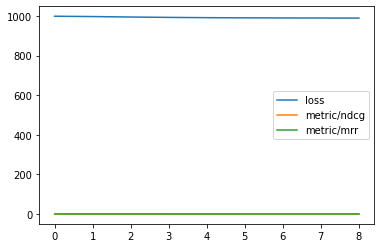

In [25]:
loss = pd.DataFrame(history.history)
loss.plot()

In [28]:
loss.head()

,loss,metric/ndcg,metric/mrr
0,998.760376,0.822293,1.0
1,997.141357,0.915633,1.0
2,994.839417,0.937608,1.0
3,992.977417,0.958287,1.0
4,991.593689,0.970687,1.0


In [20]:
for movie_titles in feature_data.batch(2000):
  break

inputs = {
    "user_id":
        tf.expand_dims(tf.repeat("26", repeats=movie_titles.shape[0]), axis=0),
    "movie_title":
        tf.expand_dims(movie_titles, axis=0)
} 

In [21]:
scores = model(inputs)
titles = tfr.utils.sort_by_scores(scores,
                                  [tf.expand_dims(movie_titles, axis=0)])[0]

In [22]:
print(f"Top 10 recommendations for user 26: {titles[0, :10]}")

Top 10 recommendations for user 26: [b'L.A. Confidential (1997)' b'Silence of the Lambs, The (1991)'
 b'Shawshank Redemption, The (1994)' b'12 Angry Men (1957)'
 b'To Kill a Mockingbird (1962)' b'Alice in Wonderland (1951)'
 b'All About Eve (1950)' b'Fargo (1996)' b'Philadelphia (1993)'
 b'Titanic (1997)']


## Ressources
- https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/metrics

- https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/metrics/NDCGMetric